# Computational Statistics - Problem 17
It is not always possible to perform a cross validation as in problem 16 (e.g.
due to run time or lack of a sufficient number of observations or a reliable
ground truth). An alternative is the usage of model based selection criteria.
The most popular selection criteria are the Akaike information criterion (AIC)
and the Bayesian information criterion (BIC). The AIC is given by $AIC =
n log(RSS=n)-nlog(n)+2log(df)$, where $RSS = \sum_{i=1}^{n}(y_i * \hat{y_i})^2$ are the residual
sum of squares, n is the number of observations and df is the number of degrees
of freedom required for the estimate. The $ BIC = n log(RSS/n) - nlog(n) +
nlog(df) $ is dened very similar and favors less complex models. We use the
same EHEC data as in problem 16 to now derive the best model for prediction
based on the AIC and BIC.

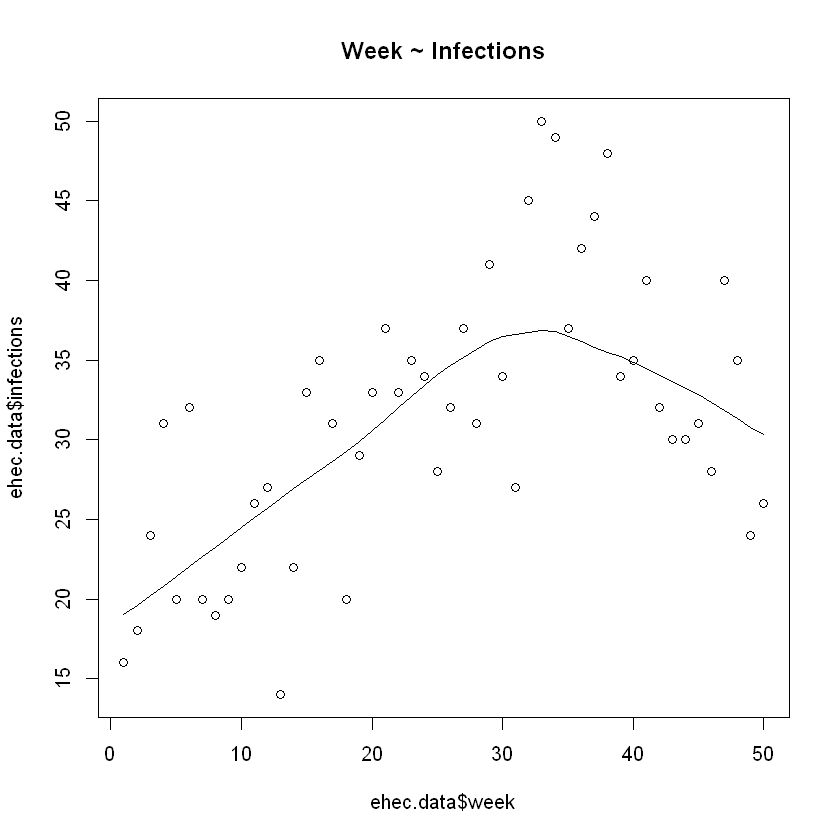

In [1]:
ehec.data <- read.table('./ehec.csv', sep = ';', header = FALSE, col.names=c('week', 'infections'))
scatter.smooth(x=ehec.data$week, y=ehec.data$infections, main="Week ~ Infections")

## A

The degrees of freedom of a regression estimator is the number of parameters
to be estimated. Equivalently, for an estimator of the type $\hat{Y} = SY$
it is also the trace of the hat matrix S, $ tr(S) = \sum_{i=1}^n S_{ii}$. Determine the
degrees of freedom for the linear regression model of 16 A using these
two approaches.

In [74]:
lin.reg <- lm(week ~ infections, ehec.data)
lin.reg$coefficients

print("Linear regression has 2 parameters -> df = 2")

print(paste("df:", sum(lm.influence(lin.reg)$hat)))

X <- ehec.data$infections
H <- X %*% solve(t(X) %*% X) %*% t(X)
print(paste("df calculated with trace 'by hand':", sum(diag(H))))
print("-> difference due to intercept")

(Intercept)  infections 
  -3.056091    0.914673

[1] "Linear regression has 2 parameters -> df = 2"
[1] "df: 2"
[1] "df calculated with trace 'by hand': 1"
[1] "-> difference due to intercept"


## B

For the Nadaraya-Watson estimator, we can only rely on estimating the
trace of the hat matrix. The hat matrix of the Nadaraya-Watson estimator
can be computed using the following R-function. Compute the
degrees of freedom for a Nadaraya-Watson estimator with a Gaussian
kernel and bandwidths h2 = 2, h3 = 5, and h4 = 10.

In [3]:
#funtion provided in exercise sheet
getHatMatrix <- function(x,h){
    #initialiaze a 0 matrix
    Snw <- matrix(0, nrow = length(x), ncol = length(x))
    #get a matrix of the standard basis vectors
    In <- diag(length(x)) ## identity matrix
    #add influence of each standard basis vector
    for(j in 1:length(x)){
        y <- In[,j]
        Snw[,j] <- ksmooth(x,y,bandwidth=h,x.points=x)$y
    }
    return(Snw)
}

getDf <- function(x,h) {
    hat = getHatMatrix(ehec.data$infections, h)
    return(sum(diag(hat)))
}

hs <- c(1, 2, 5, 10)
for(h in hs) {
    print(paste('h = ', h, ': df = ', getDf(ehec.data$infections, h), sep = ''))
}

[1] "h = 1: df = 2.33333333333333"
[1] "h = 2: df = 1.61111111111111"
[1] "h = 5: df = 2.20476925035749"
[1] "h = 10: df = 1.70989024047848"


## C
Compute the residual sum of squares (RSS) for all bandwidths considered
and for the linear regression model.

In [55]:
rss <- function(y, y.hat) {
    return(sum((y - y.hat)^2))
}

for(h in hs) {
    y.hat <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)$y
    print(paste('h = ', h, ': rss = ', rss(ehec.data$infections, y.hat), sep = ''))
}

rss.lin.reg <- sum((lin.reg$residuals)^2)
rss.lin.reg



[1] "h = 1: rss = 0"
[1] "h = 2: rss = 722.666666666667"
[1] "h = 5: rss = 1295.46055555556"
[1] "h = 10: rss = 1416.6471516859"


[1] 7391.792

## D
Compute the AIC for all models. Which model has the smallest AIC
and should thus be prefered?

In [68]:
aic <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + 2 * log(df))
}

aic2 <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + 2 * df)
}

aic(50, rss.lin.reg, 2)
aic2(50, rss.lin.reg, 2)
AIC(lin.reg)
extractAIC(lin.reg)[2]

for(h in hs) {
    kernel <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)
    y.hat <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)$y
    kernel.rss <- rss(ehec.data$infections, y.hat)
    kernel.aic <- aic(50, kernel.rss, getDf(ehec.data$infections, h))
    kernel.aic2 <- aic2(50, kernel.rss, getDf(ehec.data$infections, h))
    
    print(paste('h = ', h, ': aic (exercise) = ', kernel.aic, sep = ''))
    print(paste('h = ', h, ': aic (slides) = ', kernel.aic2, sep = ''))
}

[1] 55.59027

[1] 58.20398

[1] 397.699

[1] 253.8051

[1] "h = 1: aic (exercise) = -Inf"
[1] "h = 1: aic (slides) = -Inf"
[1] "h = 2: aic (exercise) = -61.1010487040626"
[1] "h = 2: aic (slides) = -58.832674626021"
[1] "h = 5: aic (exercise) = -31.2899772195028"
[1] "h = 5: aic (slides) = -28.4616844289055"
[1] "h = 10: aic (exercise) = -27.3270322858685"
[1] "h = 10: aic (slides) = -24.9801101681112"


## E
Compute the BIC for all models. Which model has the smallest BIC
and should thus be prefered?

In [72]:
bic <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + n * log(df))
}

bic2 <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + df * log(n))
}

bic(length(lin.reg$residuals), rss.lin.reg, 2)
BIC(lin.reg)

for(h in hs) {
    kernel <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)
    y.hat <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)$y
    kernel.rss <- rss(ehec.data$infections, y.hat)
    kernel.bic <- bic(50, kernel.rss, getDf(ehec.data$infections, h))
    kernel.bic2 <- bic2(50, kernel.rss, getDf(ehec.data$infections, h))
    
    print(paste('h = ', h, ': bic (exercise) = ', kernel.bic, sep = ''))
        print(paste('h = ', h, ': bic (slides) = ', kernel.bic2, sep = ''))
}

[1] 88.86134

[1] 403.435

[1] "h = 1: bic (exercise) = -Inf"
[1] "h = 1: bic (slides) = -Inf"
[1] "h = 2: bic (exercise) = -38.2086932437278"
[1] "h = 2: bic (slides) = -55.7521931172757"
[1] "h = 5: bic (exercise) = 6.65991982332125"
[1] "h = 5: bic (slides) = -24.2461149005615"
[1] "h = 10: bic (exercise) = -1.57843156907759"
[1] "h = 10: bic (slides) = -21.7107606915593"
